In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
#import temp_modeling
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.api import Holt
from dateutil.relativedelta import relativedelta


# for presentation purposes
import warnings
warnings.filterwarnings("ignore")



# plotting defaults
plt.rc('figure', figsize=(18, 8))
plt.style.use('seaborn-whitegrid')
plt.rc('font', size=16)

# Forecasting Temperatures for the State of Maine

<div class="alert alert-block alert-info">
<b>Purpose:</b> The goal of this project is to practice my skills with timeseries data using earth surface temperature data from Berkeley Earth obtained via Kaggle.com.  I have selected my homestate of Maine as the specific location to focus on.
    
    Goals:  1. Anaylze the patterns in temperature over time
            2. Create a model that can predict monthly temperature in the state of Maine
            3. Use the model to predict 2021 data and see if it is close to what occurred in 2021
</div>

<hr style="border:10px solid purple">

## Data Aquisition

In [2]:
#  Utilizing a csv originally downloaded from:
        #  https://www.kaggle.com/berkeleyearth/climate-change-earth-surface-temperature-data
df = pd.read_csv('GlobalLandTemperaturesByState.csv')
df.head(1)

,dt,AverageTemperature,AverageTemperatureUncertainty,State,Country
0,1855-05-01,25.544,1.171,Acre,Brazil


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 645675 entries, 0 to 645674
Data columns (total 5 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   dt                             645675 non-null  object 
 1   AverageTemperature             620027 non-null  float64
 2   AverageTemperatureUncertainty  620027 non-null  float64
 3   State                          645675 non-null  object 
 4   Country                        645675 non-null  object 
dtypes: float64(2), object(3)
memory usage: 24.6+ MB


<div class="alert alert-block alert-info">
<b>Acquisition Takeaways:</b> 
    
        1. Over 600K rows with ~25K null values in temperature and temperature uncertainty
        2. Column names are a little unwieldy
        3. Temperature is in Celcius.  Confirmed by data documentation on Kaggle.com
        4. Date column can easily be converted to datetime
</div>

## Data Preparation

In [4]:
# perform initial conversions to make the data easier to work with
df.columns = df.columns.str.lower()  #lowercase column names           
df = df[df.state == 'Maine']         #filter rows so that only the state of Maine remains
df.dt = pd.to_datetime(df.dt)        #convert dt to a datetime object
df = df.set_index('dt')              #set the date as the index
df['month'] = df.index.month_name()  #add month column
df['year'] = df.index.year           #add year column
# rename columns
df = df.rename(columns={'averagetemperature' : 'temp',
                        'averagetemperatureuncertainty' : 'uncertainty'})

df.temp = (df.temp * 9/5) + 32       #convert temperature from Celcius to Farenheit


In [5]:
df.head(1)

,temp,uncertainty,state,country,month,year
dt,,,,,,
1743-11-01,29.8004,2.001,Maine,United States,November,1743


#### Are all of the rows for the location we intended?  Is there a state of Maine in another country that remains in my data?

In [6]:
df.country.value_counts()

United States    3239
Name: country, dtype: int64

#### Confirmed that all of the values are Maine in the US, meaning the state and country columns are no longer required

In [7]:
df = df.drop(columns=['country', 'state'])

In [8]:
df.head()

,temp,uncertainty,month,year
dt,,,,
1743-11-01,29.8004,2.001,November,1743
1743-12-01,NaN,NaN,December,1743
1744-01-01,NaN,NaN,January,1744
1744-02-01,NaN,NaN,February,1744
1744-03-01,NaN,NaN,March,1744


#### Initial look at the data

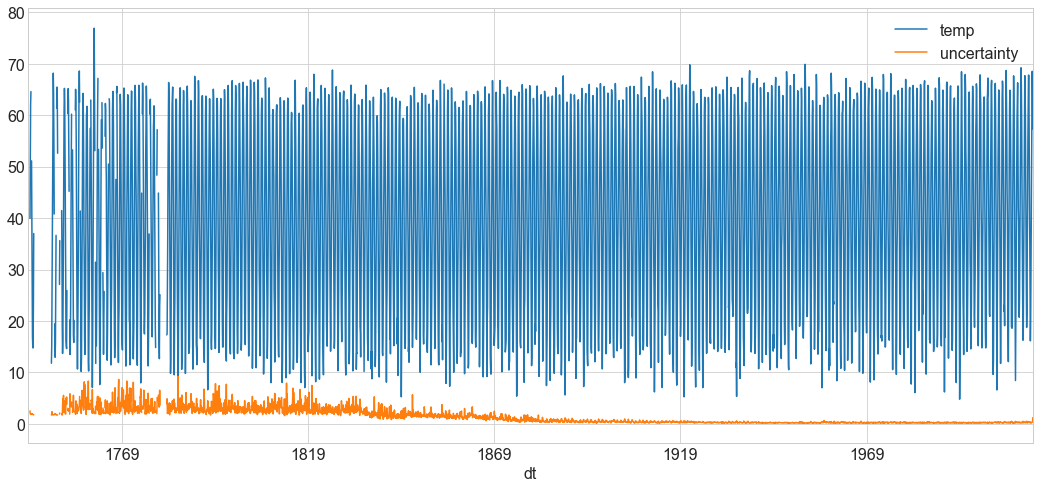

In [9]:
cols=['temp','uncertainty']
df[cols].plot()
plt.show()

#### Uncertainty prior to ~1900 seems very high, which could skew predictions.  Temperature uncertainty is related to the accuracy of the measuring equipment.  What does yearly rolling average of temp uncertainty look like?

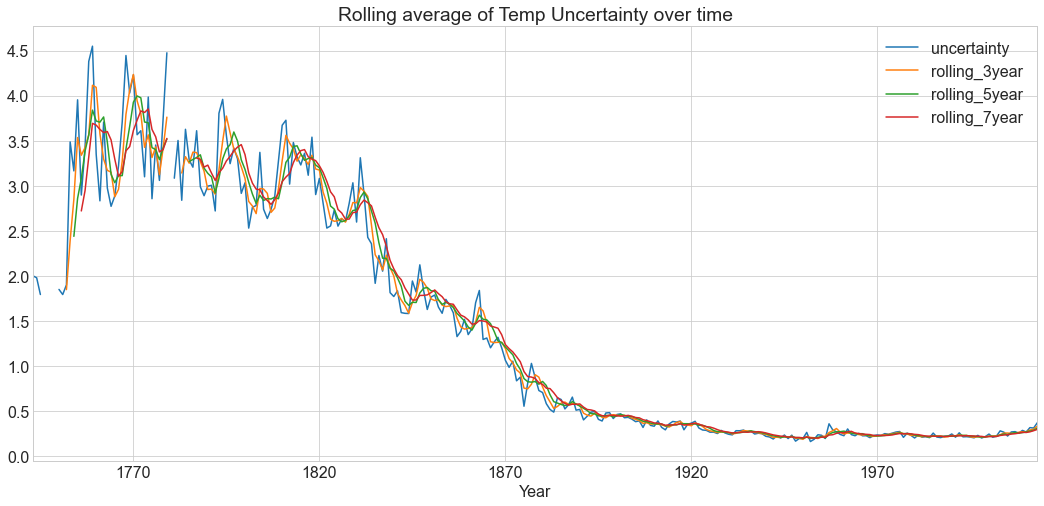

In [10]:
rolling_df=df.resample('Y').mean().assign(
    rolling_3year=lambda df: df.uncertainty.rolling(3).mean(),
    rolling_5year=lambda df: df.uncertainty.rolling(5).mean(),
    rolling_7year=lambda df: df.uncertainty.rolling(7).mean(),)

rolling_df.drop(columns=['temp','year'], inplace=True)
rolling_df.plot()
plt.title('Rolling average of Temp Uncertainty over time')
plt.xlabel('Year')
plt.yticks(np.arange(0, 5, .5))
plt.show()
    

####  I'll make the cutoff the first year the 7-year rolling average falls below that threshold

In [11]:
rolling_df[rolling_df.rolling_7year < .5].index.min()

Timestamp('1895-12-31 00:00:00', freq='A-DEC')

#### ...And crop our original data to only include the dates after that

In [12]:
df = df[df.index >= '1896']
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1413 entries, 1896-01-01 to 2013-09-01
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   temp         1413 non-null   float64
 1   uncertainty  1413 non-null   float64
 2   month        1413 non-null   object 
 3   year         1413 non-null   int64  
dtypes: float64(2), int64(1), object(1)
memory usage: 55.2+ KB


#### This also took care of our null values where there were no observations

<div class="alert alert-block alert-info">
<b>Prepare Takeaways:</b> 
    
        1. Changed column names, indexed by date, and removed unneeded columns
        2. Converted temperature to Farenheit
        3. Used 7-year rolling average of temperature uncertainty to get a reliable dataset
        4. Remaining dataset is from Jan-1896 to Sep-2013
</div>

<hr style="border:10px solid purple">

## Data Exploration

#### Split data into Train, Validate, and Test

In [13]:
# Because seasonality for temperature observations is a year, we want to split evenly on years
# Split will be approximately 50%, 30%, 20%
train = df.loc[:'1954']
validate = df.loc['1955':'1989']
test = df.loc['1990':]

In [14]:
# ensure there is no overlap
train.index.max(), validate.index.min(), validate.index.max(), test.index.min()

(Timestamp('1954-12-01 00:00:00'),
 Timestamp('1955-01-01 00:00:00'),
 Timestamp('1989-12-01 00:00:00'),
 Timestamp('1990-01-01 00:00:00'))

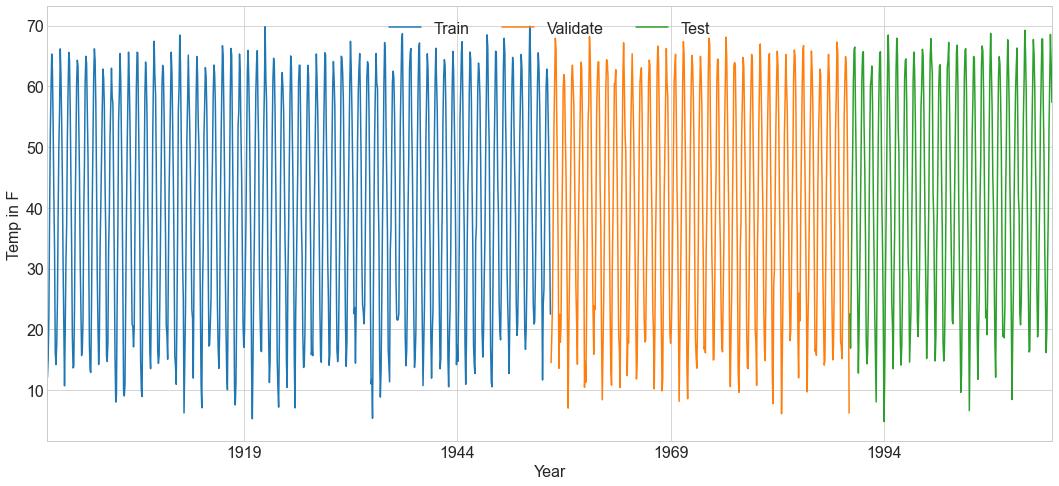

In [15]:
train.temp.plot()
validate.temp.plot()
test.temp.plot()
plt.legend(labels=['Train', 'Validate', 'Test'],loc='upper center',ncol=3,frameon=False)
plt.xlabel('Year')
plt.ylabel('Temp in F')
plt.show()

### What is the Average temperature by Month?



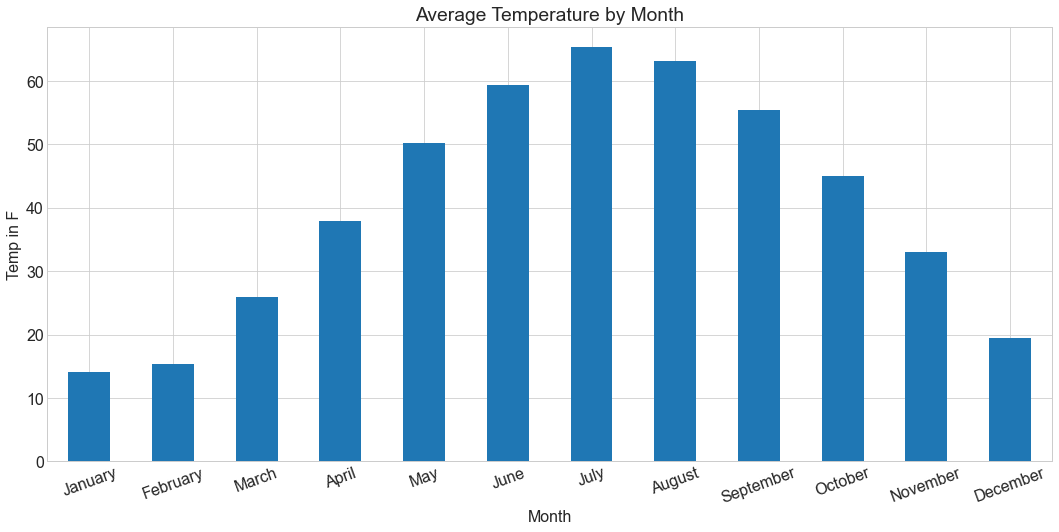

In [16]:
train.temp.groupby(train.index.month).mean().plot.bar()
plt.title('Average Temperature by Month')
plt.xticks(np.arange(0,12), ['January', 'February', 'March', 'April',
                              'May', 'June', 'July', 'August', 'September',
                              'October', 'November', 'December'], rotation=20)
plt.xlabel('Month')
plt.ylabel('Temp in F')
plt.show()

*We see expected temperatures for a seasonal climate

#### Is the Seasonal cycle yearly?

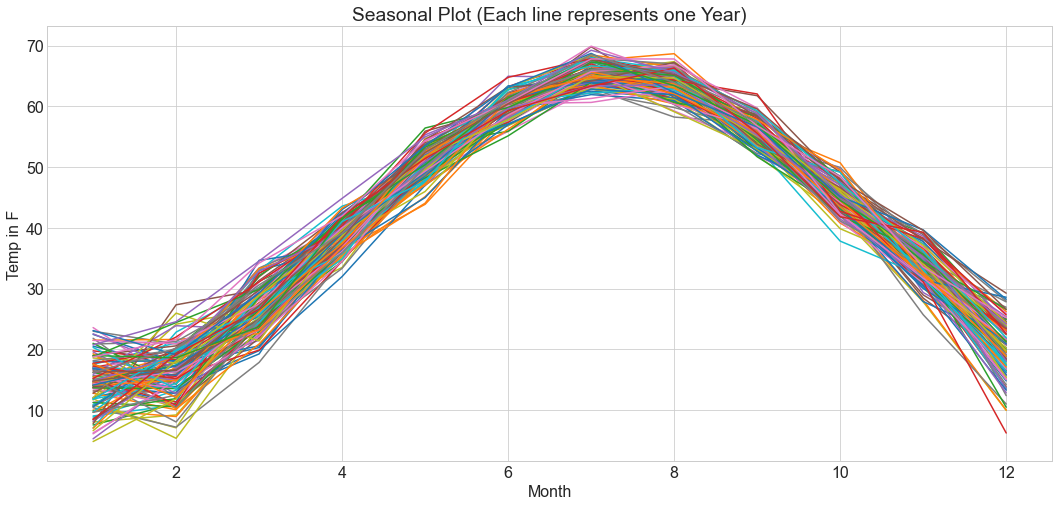

In [17]:
df.temp.groupby([df.index.year, df.index.month]).mean().unstack(0).plot(title='Seasonal Plot (Each line represents one Year)')
plt.legend().set_visible(False)
plt.xlabel('Month')
plt.ylabel('Temp in F')
plt.show()

*We can visually confirm that the temperature cycles yearly*

#### What trends can be seen from resampling?

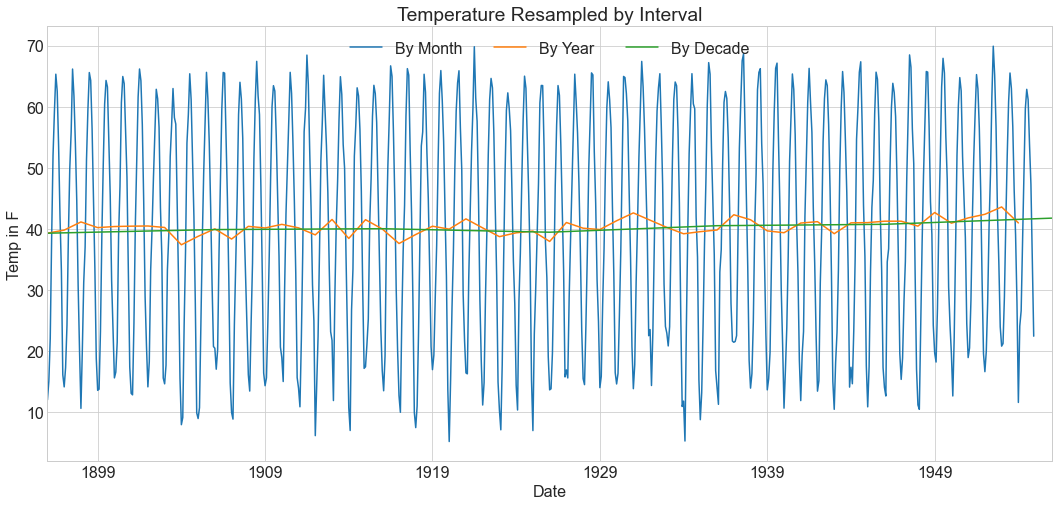

In [18]:
plt.figure(figsize=(18, 8))
train.temp.resample('M').mean().plot(label='Montly')
train.temp.resample('Y').mean().plot(label='Yearly')
train.temp.resample('10Y').mean().plot(label='Yearly')
plt.title('Temperature Resampled by Interval')
plt.xlabel('Date')
plt.ylabel('Temp in F')
plt.legend(labels=['By Month', 'By Year', 'By Decade'],loc='upper center',ncol=3,frameon=False)
plt.show()

In [19]:
print('Minimum temp resampled by decade', train.temp.resample('10Y').mean().min())
print('Maximum temp resampled by decade', train.temp.resample('10Y').mean().max())


Minimum temp resampled by decade 39.32375
Maximum temp resampled by decade 41.7874625


*Resampling by decade shows a slight upward trend over the course of the entire training set*  
* What is the rate of increase?*

In [20]:
# confirm that the first decade is the min, last decade is the max
train.temp.resample('10Y').mean()

dt
1896-12-31    39.323750
1906-12-31    39.916685
1916-12-31    40.059290
1926-12-31    39.484850
1936-12-31    40.551695
1946-12-31    40.776710
1956-12-31    41.787462
Freq: 10A-DEC, Name: temp, dtype: float64

In [21]:
# calculate average increase per year
max_temp = train.temp.resample('10Y').mean().max()
min_temp = train.temp.resample('10Y').mean().min()
years = len(train.temp.resample('Y').mean())
increase = (max_temp - min_temp) / years
print('Average temperature increased', increase, 'per year')

Average temperature increased 0.04175783898305084 per year


<div class="alert alert-block alert-info">
<b>Exploration Takeaways:</b> 
    
        1. Temperatures are much colder in winter months as we would expect for a northern location
        2. Seasonal cycle is yearly
        3. Average temperature has trended upward over time, roughly .04 degrees per year
</div>

<hr style="border:10px solid purple">

In [22]:
# evaluation function to compute rmse
def evaluate(target_var):
    rmse = round((mean_squared_error(validate[target_var], yhat_df[target_var])**.5), 2)
    return rmse

In [23]:
# plot and evaluate 
def plot_and_eval(model, target_var):
    plt.plot(train[target_var], label = 'Train', linewidth = 1)
    plt.plot(validate[target_var], label = 'Validate', linewidth = 1)
    plt.plot(yhat_df[target_var])
    plt.title(model.title())
    plt.legend(['Train', 'Validate', 'Predicted'])
    rmse = evaluate(target_var)
    print(target_var.title(), '-- RMSE: {:.0f}'.format(rmse))
    plt.show()

In [24]:
# Create the empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])

# function to store rmse for comparison purposes
def append_eval_df(model_type, target_var):
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var], 'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

# Modeling

## Last Observed Value

Temp -- RMSE: 26


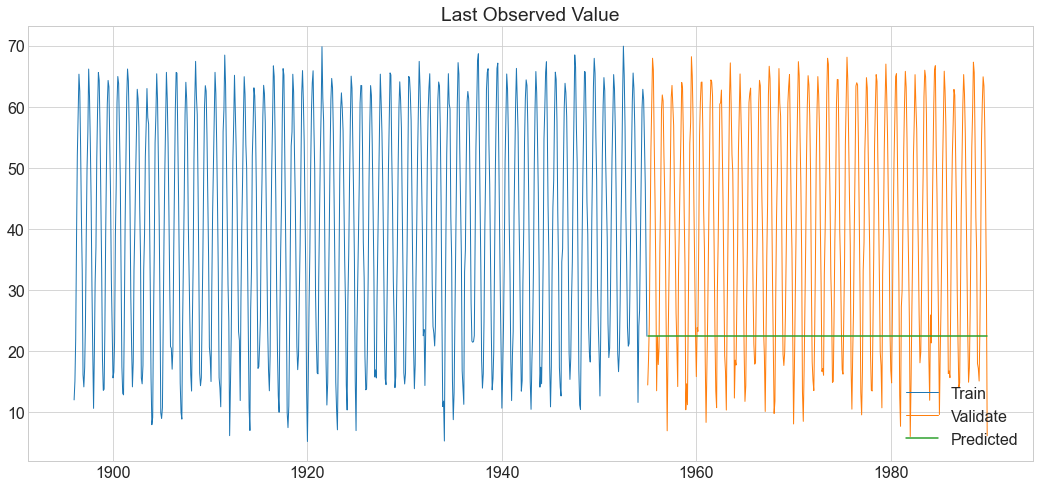

In [25]:
# Make predictions, plot, and evaluate
temps = train['temp'][-1:][0]
yhat_df = pd.DataFrame({'temp': [temps]}, 
                       index = validate.index)
plot_and_eval('Last Observed Value', 'temp')

#### Last Observed Value is not a good predictor of temperature

## Simple Average

Temp -- RMSE: 18


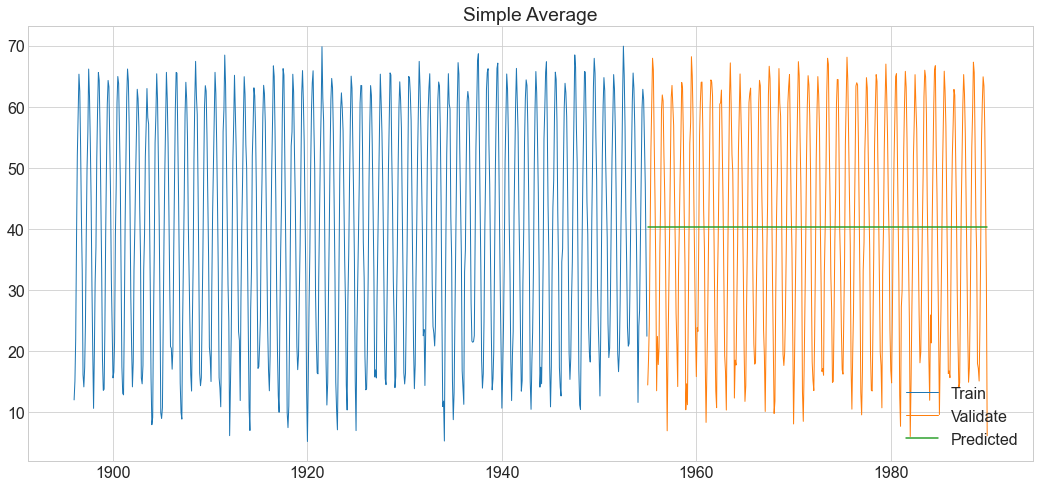

In [26]:
temps = round(train['temp'].mean(), 2)
yhat_df = pd.DataFrame({'temp': [temps]}, index = validate.index)
plot_and_eval('Simple Average', 'temp')

#### Simple average is better, but still not effective

## 12-Month Rolling Average

Temp -- RMSE: 18


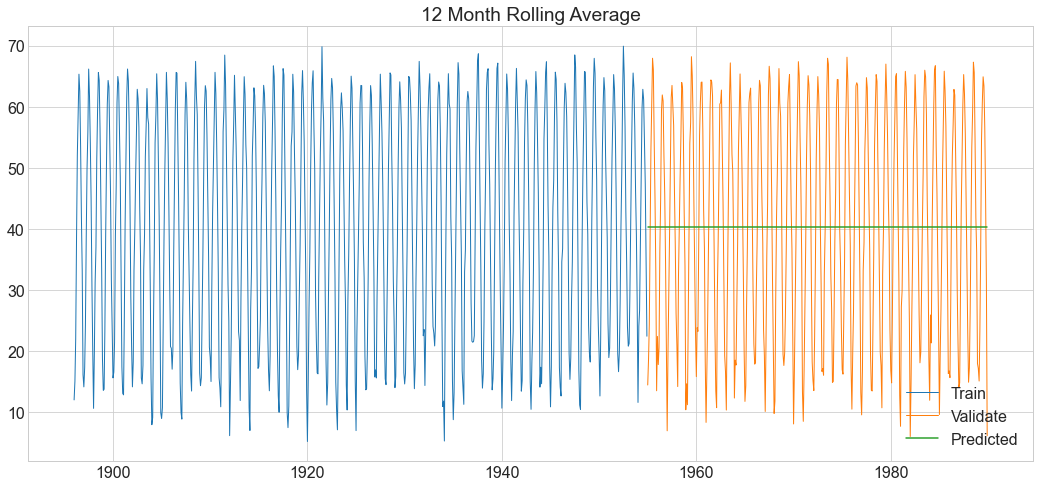

In [27]:
items = round(train['temp'].rolling(12).mean().iloc[-1], 2)
yhat_df = pd.DataFrame({'temp': [temps]}, index = validate.index)
plot_and_eval('12 Month Rolling Average', 'temp')

#### Performance is the same as Simple Average, still not effective

## Holt's Linear Trend

Temp -- RMSE: 20


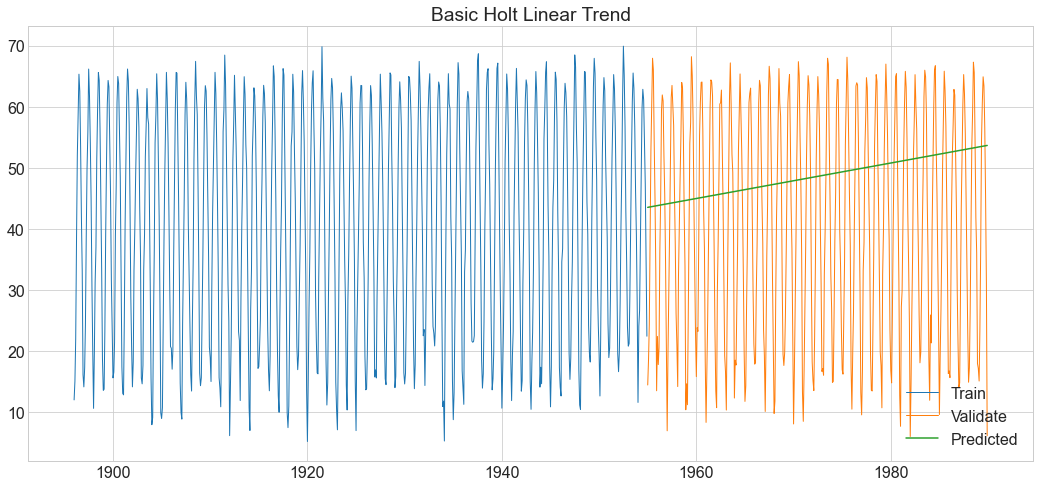

In [28]:
model = Holt(train['temp'], exponential = False)
model = model.fit(smoothing_level = .1, 
                  smoothing_slope = .1, 
                  optimized = False)
yhat_items = model.predict(start = validate.index[0], 
                           end = validate.index[-1])
yhat_df['temp'] = round(yhat_items, 2)
plot_and_eval("Basic Holt Linear Trend", 'temp')

#### Performance is worse than Simple/Moving Averages

## Predict based upon previous year's value

#### predict next 35 years based upon previous year's values for subsequent years we add the yearly average increase i calculated earlier

In [67]:
# predict next 35 years based upon previous year's values for subsequent years we add the yearly average increase
# i calculated earlier
for i in range(1, 36):
    if i==1:
        yhat_df = pd.DataFrame(train['1954'].temp + train.temp.diff(12).mean())
    else:
        new_year = pd.DataFrame(yhat_df.tail(12).temp + test.temp.diff(12).mean())
        yhat_df = pd.concat([yhat_df,new_year])
        
yhat_df.index = validate.index

Temp -- RMSE: 4


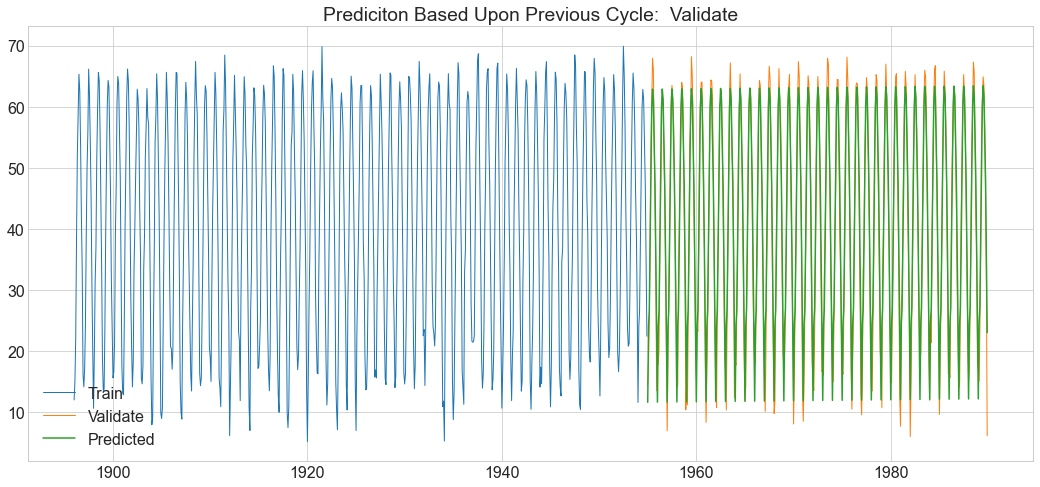

In [68]:
plot_and_eval('Prediciton based upon previous cycle:  Validate', 'temp')

#### Performance using the previous year's values is far superior

## Predicting Test values using our best model, previous year's value

In [69]:
yhat_df = validate.temp + train.temp.diff(12).mean()
yhat_df = pd.DataFrame(yhat_df.head(285))
yhat_df.index = test.index

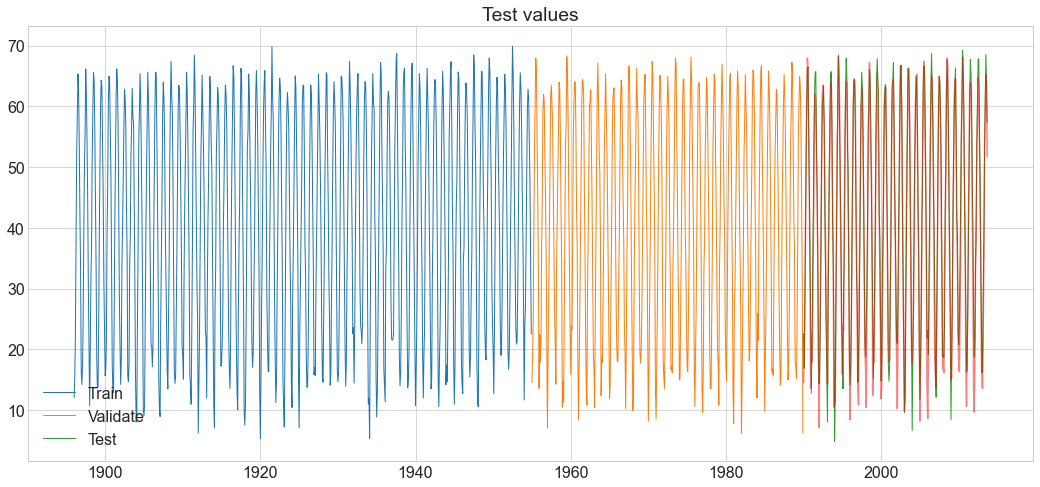

Temp -- RMSE:  4.45


In [70]:
plt.plot(train['temp'], label = 'Train', linewidth = 1)
plt.plot(validate['temp'], label = 'Validate', linewidth = 1)
plt.plot(test['temp'], label = 'Test', linewidth = 1)
plt.plot(yhat_df['temp'], alpha = .5, color="red")
plt.title('Test values')
plt.legend()
plt.show()
print("Temp -- RMSE: ", round((mean_squared_error(test['temp'], yhat_df['temp'])**.5), 2)
)

<div class="alert alert-block alert-info">
<b>Testing Takeaways:</b> 
    
        1. Last Observed Value, Averages, and Holt Linear Trend were not effective at predicting temperature
        2. Using a Previous Cycle Model I was able to predict temp with a RMSE of 4.45 degrees
</div>

## Predicting the future

#### The last complete year in the dataset is 2012, but what will the temperature look like 100 years from then?


In [74]:
# predict 101 years following the dataset
for i in range(1, 101):
    if i==1:
        yhat_df = pd.DataFrame(test['2012'].temp + test.temp.diff(12).mean())
    else:
        new_year = pd.DataFrame(yhat_df.tail(12).temp + test.temp.diff(12).mean())
        yhat_df = pd.concat([yhat_df,new_year]).tail(12)
yhat_df.index = yhat_df.index + pd.DateOffset(years=100)

In [75]:
yhat_df['100-yrs-earlier'] = test.loc['2012'].temp.values
yhat_df['diff'] = yhat_df.temp - yhat_df['100-yrs-earlier'] 

In [76]:
yhat_df

,temp,100-yrs-earlier,diff
dt,,,
2112-01-01,20.362215,18.7376,1.624615
2112-02-01,23.209815,21.5852,1.624615
2112-03-01,35.820615,34.1960,1.624615
2112-04-01,43.600215,41.9756,1.624615
2112-05-01,56.004015,54.3794,1.624615
2112-06-01,62.349015,60.7244,1.624615
2112-07-01,69.435615,67.8110,1.624615
2112-08-01,69.435615,67.8110,1.624615
2112-09-01,58.435815,56.8112,1.624615


<div class="alert alert-block alert-info">
<b>Predictions Takeaways:</b> 
    
        1. Using our model, temperatures will be 1.62 degrees warmer in 100 years
</div>

<hr style="border:10px solid purple">

## Conclusion

<div class="alert alert-block alert-info">
<b>Summary:</b> The goal of this project was to practice my skills with timeseries data using a sample dataset, and forecast the temperatures into the future.  I found that for cyclical data such as temperature our model using previous year's values was the most effective, and I was able to make a fun prediction for the future!  If I had more time I would try to find other modeling techniques to try.
</div>